### K-means spherical clustering

His work is from here: https://core.ac.uk/reader/30341728 (shorter paper) and https://peerj.com/articles/488/ (longer paper) and code is located here https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt

#### Notes 
- Mel spectrograms used directly as features

#### Outline of work
##### Preprocessing step
- Resample to standard 44.1kHz
- Spectrogram (frame size of 1024 frames with Hamming windowing and no overlap)
- Calculate Mel spectrogram for each file (which are directly used as features)
- High-pass filtering (filter spectral energy below 500 Hz to reduce environmental noise)
- RMS normalization in each spectrogram
- Spectral median noise reduction (http://sabiod.univ-tln.fr/NIPS4B2013_book.pdf aka common median-based thresholding)
- PCA-whiten the data: https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt

##### Classification
- Apply spherical k-means clustering
- Use random forest classifier on feature data (from scikit-learn)

In [4]:
import os 
import pydub
from pydub import AudioSegment
from scipy.io import wavfile
import samplerate
import librosa
from scipy import signal
import numpy as np
from librosa import feature
from librosa import filters
from scipy.signal import butter, filtfilt
from scipy import ndimage
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pydub
from pydub import AudioSegment
import tempfile
import soundfile as sf
import scipy
from scipy.io.wavfile import write
import sounddevice as sd

#### Functions to use

In [5]:
def read_mp3(f, normalized=False):
    """
    Inputs: MP3 to numpy array, f = filename
    Output: a.frame_rate (sampling rate)
    """
    a = pydub.AudioSegment.from_file(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return np.float32(y) / 2**15, a.frame_rate
    else:
        return y, a.frame_rate

def resample(filepath, des_sr=44100): 
    """
    filepath = path to desired file
    data = input data from audio file
    des_sr = desired sampling rate in Hz
    """
    filename = os.path.basename(filepath) 
    print(filename)
    if filename.endswith(".mp3") or filename.endswith(".MP3"): 
        data, sr = read_mp3(filepath)
        output_data = samplerate.resample(data, des_sr/sr, 'sinc_best')
    elif filename.endswith(".wav") or filename.endswith(".WAV"): 
        sr, data = wavfile.read(filepath)
        output_data = samplerate.resample(data,des_sr /sr, 'sinc_best')
    else: 
        print("Not a valid file type (not .wav or .mp3)")
        pass 
        
    return output_data

# Reference: https://stackoverflow.com/questions/39032325/python-high-pass-filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def high_pass_filter(data, sr): 
    # set as a highpass filter for 500 Hz
    filtered_signal = butter_highpass_filter(data, 500, sr, order=5)
    return filtered_signal

# Referenced librosa: https://github.com/librosa/librosa/blob/main/librosa/feature/spectral.py
def make_mel_spectrogram(input_data, sample_rate): 
    """
    input data: (Time series of measurement values)
    output = S : np.ndarray [shape=(n_mels, t)]
    
    melspectrograms in itself are used as features
    """
    
    f, t, Sxx = signal.spectrogram(input_data, fs=sample_rate, window = 'hamming', noverlap=None, nfft = 256, mode='magnitude')
    # Sxx is spectrogram of x and last axis of Sxx is segment times
    mel_basis = filters.mel(sample_rate, n_fft = 256)
    output = np.dot(mel_basis, Sxx)
    return output

def plot_mel_spectrogram(data): 
    mel_spect = librosa.feature.melspectrogram(y=data, sr=44100, n_fft=1024, hop_length=512)
    S_dB = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
    
    plt.title('Mel Spectrogram');
    plt.colorbar(format='%+2.0f dB');


def median_denoising(data): 
    """
    Using scipy's median filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html
    """
    # every frame, subtract the median value of spectral band
    result = ndimage.median_filter(data, 3)
    return result
    
def plot_librosa_graph(data):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.semilogy(rms.T, label='RMS')
    plt.xticks([])
    plt.xlim([0, rms.shape[-1]])
    plt.legend(loc='best')
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(data, ref=np.max),
                             y_axis='log', x_axis='time')
    plt.title('log Power spectrogram')
    plt.tight_layout()
    
def convert_mp3_to_wav(mp3_path, sr=44100, mono=True, overwrite=False, dtype='float32'): 
    # Need to change sample rate to 44.1kHz if using audiomoths
    # since mono=True by default, unless you pass mono=False, 
    # this function will save the wav as mono
#     print("entering convert_mp3_to_wav")
    """
    Parts of code from 
    https://github.com/bill317996/Audio-to-midi/blob/master/cfp.py
    """
    
#     warnings.warn("deprecated", DeprecationWarning)
    
    # in case there is an .MP3
    assert mp3_path.lower().endswith('.mp3'), 'filename indicates not mp3'
    wav_path_to_write = os.path.splitext(mp3_path)[0] + '.wav'
    if not overwrite and os.path.exists(wav_path_to_write):
        return
    
    mp3 = AudioSegment.from_file(mp3_path)
    
    _, temp_path = tempfile.mkstemp() 
    mp3.export(temp_path, format='wav')
    del mp3
    x, fs = sf.read(temp_path)
    os.remove(temp_path)
    
    if mono and len(x.shape)>1: 
        x = np.mean(x, axis = 1) 
    if sr:
        x = scipy.signal.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)
    write(wav_path_to_write, fs, x)
    return x, fs  


In [6]:
def find_n_second_multiples_and_filenames(dir_path, n, des_sr): 
    """ 
    dir_path (path): path of a directory with desired files
    n (int): split data into n-second clips
    # Note that this function also resamples!
    
    #TODO: reduce the numpy array (wav_data)
    """
    wav_data = []
    allfilenames = []
    # entire filename 
    timestamp = []

    for filename in os.listdir(dir_path):
        filepath = os.path.join(dir_path, filename)
        print(filepath)
        
        if filepath == ".DS_Store": 
            print("oh no")
            pass 
        elif filename.endswith(".mp3") or filename.endswith(".MP3"): 
            data, sr = convert_mp3_to_wav(filepath)
            print("sr", sr)
            
        elif filename.endswith(".wav") or filename.endswith(".WAV"):
            sr, data = wavfile.read(filepath)
            print(data)
            # comment out previous for no resampling
            data = samplerate.resample(data, des_sr/sr, 'sinc_best')
            sr = des_sr
            
        num_samples_in_n_seconds =  n  * sr 
        length_data = len(data)
        length_in_seconds = length_data / sr 
        
        if length_data < num_samples_in_n_seconds: 
            pass
        
        elif length_data > num_samples_in_n_seconds: 
            data = data[:-(length_data % num_samples_in_n_seconds)]
            num_of_n_clips = int(np.floor(length_data / num_samples_in_n_seconds))
            
            for i in range(num_of_n_clips): 
#                 allfilenames.append(list_file_name[0]+list_file_name[1])
                allfilenames.append(filename)
                data_n_seconds = data[i*num_samples_in_n_seconds:(i+1)*num_samples_in_n_seconds]
                timestamp.append([i*n,(i+1)*n])
                wav_data.append(data_n_seconds)

        else: #length_data == num_samples_in_n_seconds: 
            allfilenames.append(filename)
            wav_data.append(data)
            
    return wav_data, allfilenames, timestamp

## Convert mel spectrogram back to time domain 
Testing the effectiveness of converting spectrograms back to audio files

In [7]:
# References: 
# https://github.com/librosa/librosa/issues/843 
# https://stackoverflow.com/questions/60365904/reconstructing-audio-from-a-melspectrogram-has-some-clipping-with-librosa

# convert mel spectrogram to 
example_dir = '/Volumes/Elements/One_audio_file/20190611_081000.WAV'

# load audio data 
# sr, data = wavfile.read(example_dir)
data_librosa_rs, sr = librosa.load(example_dir, sr=44100)
print(sr)

44100


In [8]:
data_hp = high_pass_filter(data_librosa_rs, 44100)
data_hp_fortran = np.asfortranarray(data_hp)

In [9]:
# # mel spectrogram (as above)
mel_spect = librosa.feature.melspectrogram(y=data_hp_fortran, sr=44100)

In [10]:
S_mel = librosa.feature.inverse.mel_to_stft(mel_spect)
mel_spect_data = librosa.griffinlim(S_mel)

In [20]:
# skip for now
rms = librosa.feature.rms(y=None, S=S_mel, frame_length = 2048) #frame_length = 254
# for each frame, needs to be divided by RMS
print(rms.shape)
print(S_mel.shape)
S_norm = S_mel/rms
print(S_norm.shape)

(1, 5168)
(1025, 5168)
(1025, 5168)


In [21]:
S_rms = librosa.feature.inverse.mel_to_stft(S_norm)
data_rms = librosa.griffinlim(S_norm)
print(data_rms.shape)

(2645504,)


In [22]:
sd.play(data_rms, 44100)

In [32]:
sd.stop()

In [24]:
sf.write('20190611_081000_resample_hp_mel_spect_rms_librosa1.wav', data_rms, 44100)


In [30]:
median_denoise = median_denoising(mel_spect_data)
print(median_denoise)

[ 0.0114959  -0.00084036 -0.00084036 ...  0.00041483  0.00041483
 -0.00246495]


In [31]:
sd.play(median_denoise, 44100)

In [33]:
sf.write('20190611_081000_resample_hp_mel_spect_median_librosa1.wav', median_denoise, 44100)


##### Preprocessing step
- Resample to standard 44.1kHz
- Spectrogram (frame size of 1024 frames with Hamming windowing and no overlap)
- Calculate Mel spectrogram for each file (which are directly used as features)
- High-pass filtering (filter spectral energy below 500 Hz to reduce environmental noise)
- RMS normalization in each spectrogram
- Spectral median noise reduction (http://sabiod.univ-tln.fr/NIPS4B2013_book.pdf aka common median-based thresholding)
- PCA-whiten the data: https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt

## Step by Step Visualization

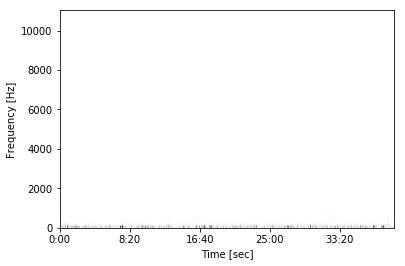

In [11]:
# Spectrogram before and after resample to standard 44.1kHz
test_dir = '/Volumes/Elements/Mixed_AM_Dataset2/20190710_172000.WAV'

#(frame size of 1024 frames with Hamming windowing and no overlap)
# Spectrogram before resampling
rate, sig = wavfile.read(test_dir)

f, t, Sxx = signal.spectrogram(sig, fs=rate, window = 'hamming', noverlap=None, nfft = 1024, mode='magnitude')
librosa.display.specshow(Sxx, cmap='gray_r', y_axis='linear', x_axis = 'time')

# plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

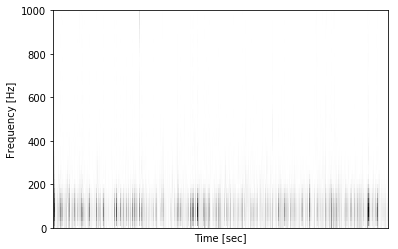

In [12]:
librosa.display.specshow(Sxx, cmap='gray_r', y_axis='linear')

# plt.pcolormesh(t, f, Sxx)
plt.ylim([0,1000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

20190710_172000.WAV


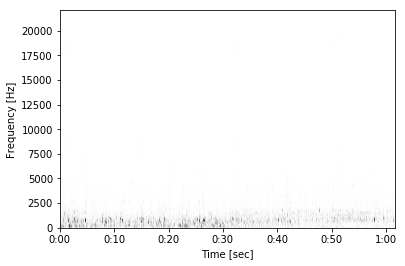

In [13]:
# Spectrogram after resampling 
resamp_sig = resample(test_dir, des_sr=44100)
f_rs, t_rs, Sxx_rs = signal.spectrogram(resamp_sig, fs=44100, window = 'hamming', noverlap=None, nfft = 1024, mode='magnitude')

# http://support.ircam.fr/docs/AudioSculpt/3.0/co/Window%20Size.html
# T = 1024/44100= 0.023
librosa.display.specshow(Sxx_rs, sr = 44100, hop_length=230, cmap='gray_r', y_axis='linear', x_axis = 'time')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

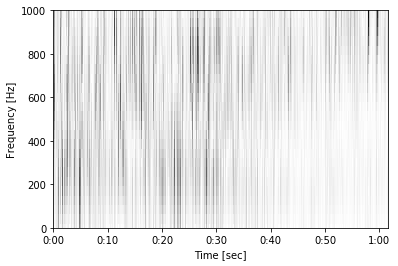

In [14]:
librosa.display.specshow(Sxx_rs, sr = 44100, hop_length=230, cmap='gray_r', y_axis='linear', x_axis = 'time')
plt.ylim([0,1000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(2645999,)


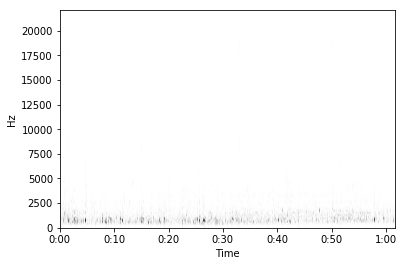

In [15]:
# High-pass filtering (filter spectral energy below 500 Hz to reduce environmental noise)

hp_d = high_pass_filter(resamp_sig, 44100)
print(hp_d.shape)

f_hp, t_hp, Sxx_hp = signal.spectrogram(hp_d, fs=44100, window = 'hamming', noverlap=None, mode='magnitude', nfft=1024)
librosa.display.specshow(Sxx_hp, sr = 44100, hop_length=230, cmap='gray_r', y_axis='linear', x_axis = 'time')

# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [s]')
# plt.show()

(0, 1000)

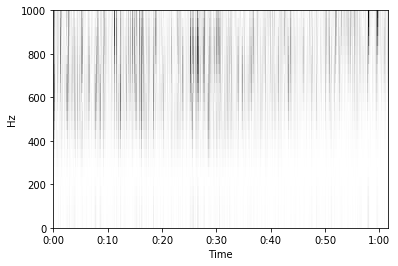

In [16]:
librosa.display.specshow(Sxx_hp, sr = 44100, hop_length=230, cmap='gray_r', y_axis='linear', x_axis = 'time')
plt.ylim([0,1000])
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [s]')
# plt.show()

(128, 11812)


Text(0.5, 1.0, 'Mel Spectrogram')

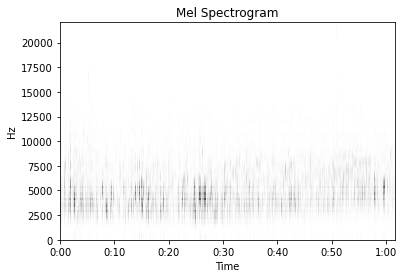

In [66]:
mel_basis = filters.mel(44100, n_fft=1024) 
mel_spect = np.dot(mel_basis, Sxx_hp) #output of melspectrogram
# change Sxx_hp to Sxx_rs to see the high pass filter difference
print(mel_spect.shape)

# for plotting purposes only 
librosa.display.specshow(mel_spect, sr = 44100, hop_length=230, cmap='gray_r', y_axis='linear', x_axis = 'time')
plt.title('Mel Spectrogram')

(1, 11812)
(128, 11812)


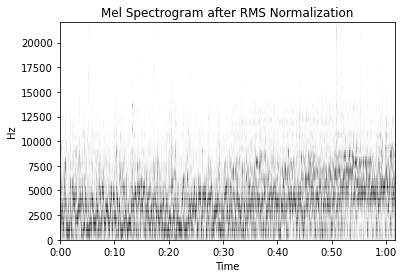

In [71]:
# RMS normalization in each spectrogram
rms = librosa.feature.rms(y=None, S=mel_spect, frame_length=254)
print(rms.shape)

# for each frame in spectrogram, divide by rms value
norm_d = mel_spect/rms
print(norm_d.shape)

librosa.display.specshow(norm_d, sr = 44100, hop_length=230, cmap='gray_r',y_axis='linear', x_axis='time'); #figure out time scale
plt.title('Mel Spectrogram after RMS Normalization');
# plt.colorbar(format='%+2.0f dB');

(129, 11810)


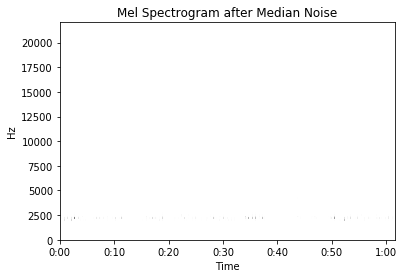

In [21]:
# Spectral median noise reduction (http://sabiod.univ-tln.fr/NIPS4B2013_book.pdf aka common median-based thresholding)
S_mel = librosa.feature.inverse.mel_to_stft(mel_spect)
mel_spect_data = librosa.griffinlim(S_mel)

median_noise = median_denoising(mel_spect_data)
frequencies, times, spectrogram = signal.spectrogram(median_noise, 44100)
print(spectrogram.shape)

librosa.display.specshow(spectrogram, sr = 44100, hop_length=230, cmap='gray_r', y_axis='linear', x_axis = 'time'); #figure out time scale
plt.title('Mel Spectrogram after Median Noise');
# plt.colorbar(format='%+2.0f dB');

## Computing for real

In [50]:
# TODO: plot all the things
dir_path = '/Volumes/Elements/Mixed_AM_Dataset2_shorter/'

shorter_clips, file_names, timestamp = find_n_second_multiples_and_filenames(dir_path, 10, 44100)
print(file_names)
print(len(file_names))

/Volumes/Elements/Mixed_AM_Dataset2_shorter/5D0E8668.WAV
[-425 -422 -291 ...  553  566  483]
/Volumes/Elements/Mixed_AM_Dataset2_shorter/5D0EA4E0.WAV
[-1354 -1619 -1914 ...  -337  -319  -253]
/Volumes/Elements/Mixed_AM_Dataset2_shorter/5D0EA738.WAV
[805 944 971 ... 199 198 133]
/Volumes/Elements/Mixed_AM_Dataset2_shorter/5D0EA990.WAV
[-426 -439 -452 ...  758  706  526]
/Volumes/Elements/Mixed_AM_Dataset2_shorter/5D0EABE8.WAV
[-1004  -886  -705 ...   910   921   980]
['5D0E8668.WAV', '5D0E8668.WAV', '5D0E8668.WAV', '5D0E8668.WAV', '5D0E8668.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV']
25


In [51]:
print(file_names)
print(len(file_names))

['5D0E8668.WAV', '5D0E8668.WAV', '5D0E8668.WAV', '5D0E8668.WAV', '5D0E8668.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA4E0.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA738.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EA990.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV', '5D0EABE8.WAV']
25


In [52]:
# TODO: need to update from the k-means spherical one
# # Resample
# d = resample('/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/XC22019 - Blue-crowned Trogon - Trogon curucui.mp3', des_sr = 44100)

final_d = []

for i in range(len(shorter_clips)): 
    print("shorter_clips[i].shape", shorter_clips[i].shape)
    output = make_mel_spectrogram(shorter_clips[i], 44100)
    hp_d = high_pass_filter(output,44100)
    # http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.rmse.html
    rms = librosa.feature.rms(y=None, S=hp_d, frame_length = 254)
    norm_d = hp_d/rms
    median_d = median_denoising(norm_d)
    median_d_transpose = median_d.T
    final_d.append(median_d_transpose.flatten())
    
print(final_d)
print(len(final_d))
print(final_d[0].shape)

shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
shorter_clips[i].shape (441000,)
[array([ 3.24510026,  3.24510026,  3.45794278, ..., 11.33837409,
        9.65996489,  4.06132124]), array([ -2.83596015,  -2.83596015,  -3.15421359, ..., -10.76160418,
       

# Clustering
Graph elbow method and visualization of clusters

In [53]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20, savepath=''):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

In [55]:
# Spherical K-means clustering
# https://github.com/jasonlaska/spherecluster
from spherecluster import SphericalKMeans
n_clusters = 3
clusters = SphericalKMeans(n_clusters).fit_predict(X)

print(clusters)
print(len(clusters))

[1 1 1 1 1 0 0 2 0 0 0 2 0 2 0 1 2 1 2 2 1 1 1 1 1]
25


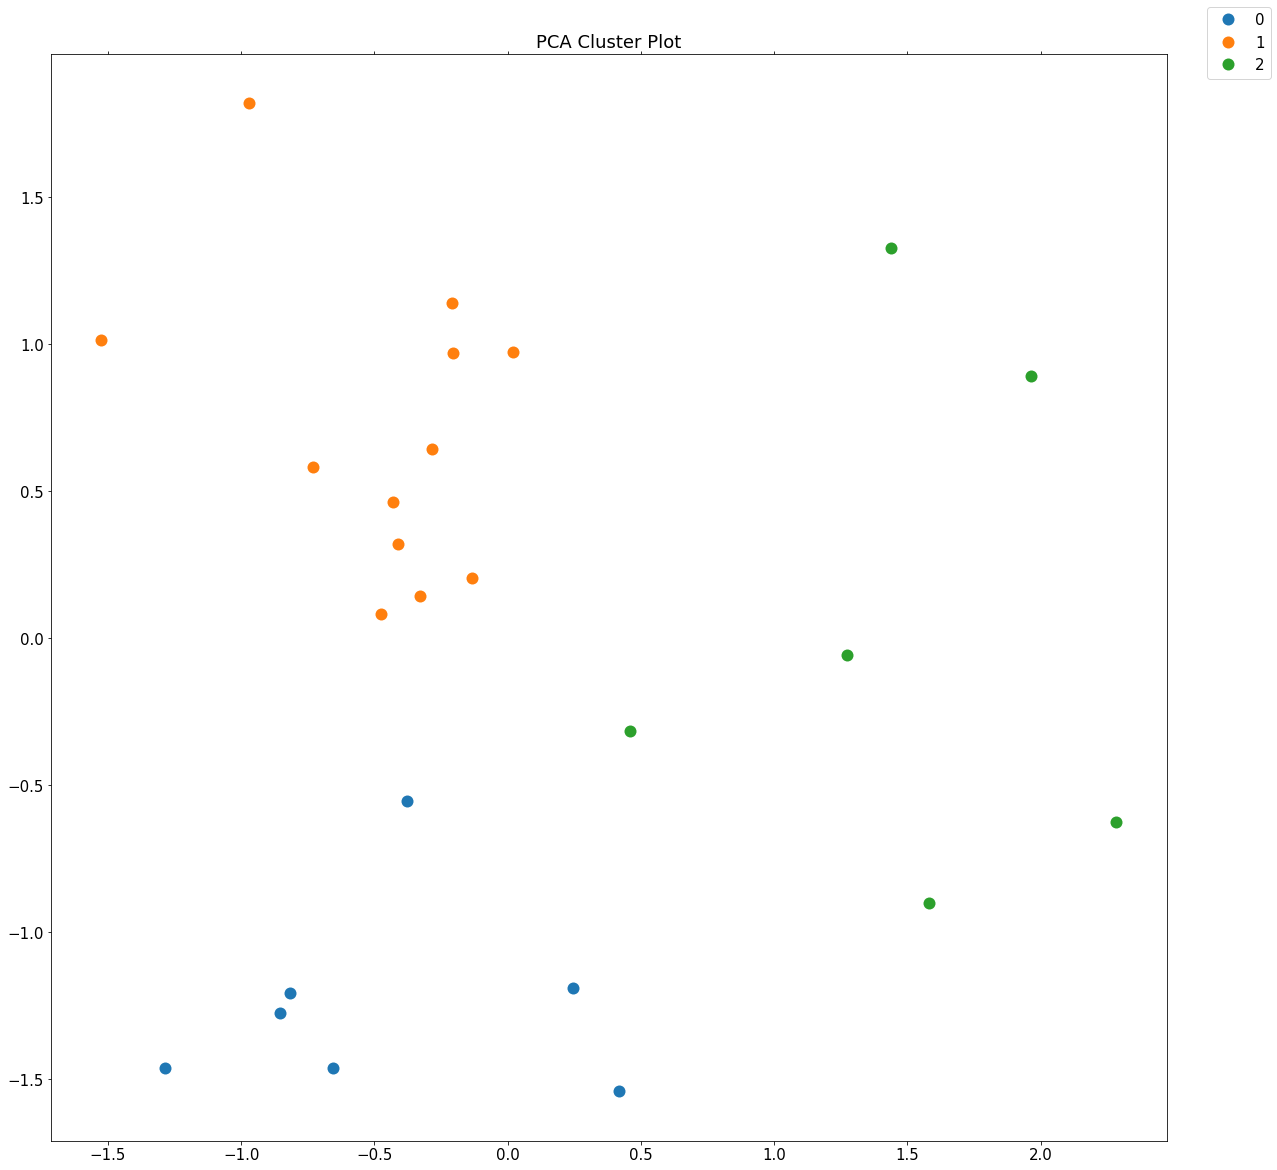

In [56]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

dist = 1 - cosine_similarity(final_d)
mds = PCA(n_components=2, random_state=1, whiten=True)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
X = pos

cluster_plot(X, 'PCA Cluster Plot', without_labels=True, savepath='/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/pca.png')

### Clustering k-means elbow

In [ ]:
Error =[]
for i in range(1, 14):
#     kmeans = KMeans(n_clusters = i).fit(X)
    kmeans = SphericalKMeans(n_clusters = i).fit(X)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 14), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

# Cluster Interpretation

In [57]:
# Returns all clip indexes within a cluster
def get_clip_indexes(cluster_label, clusters):
    clips_i = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_label:
            clips_i.append(i)
    return clips_i

# Plays a random clip in a given cluster
def play_random_clip_in_cluster(index, clusters, option='cluster'):
    assert(option == 'cluster' or option == 'clip')
    if option == 'clip':
        index = find_cluster(index, clusters) # Get cluster index
    
    clips = get_clip_indexes(index, clusters)
    clip_i = clips[random.randint(0, len(clips) - 1)]
    print('Playing clip index %d ' % clip_i)
    play_clip(clip_i)
        
# Returns the cluster label that a clip belongs to
def find_cluster(clip_index, clusters):
    return clusters[clip_index]

# Plays an audio clip given the clip index
def play_clip(clip_index):
    samples = shorter_clips[clip_index]
    sd.play(samples, sample_rate)

# Flattens a given list
def list_flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

# Saves clip as a wav file
def save_clip(filename, wav_array):
#     assert('.' not in filename)
    write(filename + '.wav', 44100, wav_array)
    
# Saves all clips to a directory
def save_clips_to_dir(shorter_clips, dirname):
    for i, clip in enumerate(shorter_clips):
        save_clip(dirname + '/%d' % i, clip) 

In [58]:
# Prints: (Cluster number, count of clips in cluster)
from collections import Counter
import random
import sounddevice as sd

Counter(clusters).most_common()

[(1, 12), (0, 7), (2, 6)]

In [59]:
sample_rate = 44100
play_random_clip_in_cluster(0, clusters) # Play random clip in a cluster

Playing clip index 12 


In [60]:
sd.stop() # Stop playing

In [61]:
play_clip(10)

In [62]:
sd.stop() # Stop playing

## Save clusters of audio files

In [63]:
print(range(len(np.unique(clusters))))
print(len(file_names))

range(0, 3)
25


In [74]:
cluster_list_ordered = []

for i in range(len(np.unique(clusters))): 
    cluster_set = set()
    for j in get_clip_indexes(i, clusters):
        cluster_list_ordered.append(i)
        print("get_clip_indexes(i, clusters)", get_clip_indexes(i, clusters))
        print("file_names[j]", file_names[j])
        print("len(file_names)", len(file_names))
        print("os.path.splitext(file_names[j])",os.path.splitext(file_names[j]))
        print(" os.path.splitext(file_names[j])[0]",  os.path.splitext(file_names[j])[0])
#         print("os.path.splitext(file_names[j])[0].split("-",1)", os.path.splitext(file_names[j])[0].split(" - ",1))
        print()
    print(cluster_set)

print(file_names)
print(cluster_list_ordered)
print(len(cluster_list_ordered))
# print(num_bird_species)   

get_clip_indexes(i, clusters) [5, 6, 8, 9, 10, 12, 14]
file_names[j] 5D0EA4E0.WAV
len(file_names) 25
os.path.splitext(file_names[j]) ('5D0EA4E0', '.WAV')
 os.path.splitext(file_names[j])[0] 5D0EA4E0

get_clip_indexes(i, clusters) [5, 6, 8, 9, 10, 12, 14]
file_names[j] 5D0EA4E0.WAV
len(file_names) 25
os.path.splitext(file_names[j]) ('5D0EA4E0', '.WAV')
 os.path.splitext(file_names[j])[0] 5D0EA4E0

get_clip_indexes(i, clusters) [5, 6, 8, 9, 10, 12, 14]
file_names[j] 5D0EA4E0.WAV
len(file_names) 25
os.path.splitext(file_names[j]) ('5D0EA4E0', '.WAV')
 os.path.splitext(file_names[j])[0] 5D0EA4E0

get_clip_indexes(i, clusters) [5, 6, 8, 9, 10, 12, 14]
file_names[j] 5D0EA4E0.WAV
len(file_names) 25
os.path.splitext(file_names[j]) ('5D0EA4E0', '.WAV')
 os.path.splitext(file_names[j])[0] 5D0EA4E0

get_clip_indexes(i, clusters) [5, 6, 8, 9, 10, 12, 14]
file_names[j] 5D0EA738.WAV
len(file_names) 25
os.path.splitext(file_names[j]) ('5D0EA738', '.WAV')
 os.path.splitext(file_names[j])[0] 5D0EA738



## Save as .csv

In [76]:
## pandas dataframe ## 
import pandas as pd 

print(len(file_names))
print(len(timestamp))
print(len(cluster_list_ordered))

data = {
    'File name': file_names,
    'Time in clip (seconds)': timestamp,
    'Cluster number': cluster_list_ordered
}

df = pd.DataFrame(data, columns = ['File name', 'Time in clip (seconds)', 'Cluster number'])

df.to_csv(r'/Volumes/Elements/Mixed_AM_Dataset2_shorter/export_dataframe_kmeanspherical.csv',index = False, header=True)
            
print(df.head())
# filename list 
# start and end time in the clip analyzed
# sample rate 
# cluster number


25
25
25
      File name Time in clip (seconds)  Cluster number
0  5D0E8668.WAV                [0, 10]               0
1  5D0E8668.WAV               [10, 20]               0
2  5D0E8668.WAV               [20, 30]               0
3  5D0E8668.WAV               [30, 40]               0
4  5D0E8668.WAV               [40, 50]               0


In [71]:
# dirname = '/Volumes/Elements/Test/Clusters/'
dirname = '/Volumes/Elements/Mixed_AM_Dataset2_shorter/Clusters/'


for i in range(len(np.unique(clusters))):
    os.mkdir(dirname + 'cluster_%d' % i)
    for j in get_clip_indexes(i, clusters):
        save_clip(dirname + 'cluster_%d/%s' % (i, file_names[j]), final_d[j])

In [ ]:
print(len(np.unique(clusters)))
print(np.unique(clusters))
print(get_clip_indexes(i, clusters))
print(len(clusters))
print(len(file_names))

## Analyze clusters 
Find the total number of bird species in cluster and also the list of dictionary of each file name corresponding to each cluster number

In [ ]:
num_bird_species = []
cluster_list_ordered = []

for i in range(len(np.unique(clusters))): 
    cluster_set = set()
    for j in get_clip_indexes(i, clusters):
        cluster_list_ordered.append(i)
        bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
#         print(bird_species)
#         print(type(bird_species))
        cluster_set.add(bird_species)
    num_bird_species.append(len(cluster_set))
    print(cluster_set)

print(file_names)
print(cluster_list_ordered)
# print(num_bird_species)        

In [ ]:
# Number of Bird Species in Every Cluster
print(len(num_bird_species))
cluster_num = range(0,len(num_bird_species))

x = cluster_num 
y = num_bird_species

# Add title, axes
plt.bar(x,y)
plt.title('Number of Bird Species in Every Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Bird Species')

average_num_birds = sum(num_bird_species)/len(num_bird_species)
print("Average number of birds over clusters:", average_num_birds)

In [ ]:
### Plot average number of birds over clusters for clusters ranging from 1 to 134

list_num_of_clusters = []
list_of_average_num_birds = []

for n in range(1,130,5):
    list_num_of_clusters.append(n)
    clusters = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)
    num_bird_species = []

    for i in range(len(np.unique(clusters))): 
        cluster_set = set()
        for j in get_clip_indexes(i, clusters):
            
            bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
    #         print(bird_species)
    #         print(type(bird_species))
            cluster_set.add(bird_species)
        num_bird_species.append(len(cluster_set))
            
    average_num_bird_species = sum(num_bird_species)/len(num_bird_species)
    list_of_average_num_birds.append(average_num_bird_species)
    
#     print(list_num_of_clusters)
#     print(list_of_average_num_birds)
    
    

In [ ]:
# Plot spectrogram of all clips in a cluster appended together
plot_spectrogram_of_cluster(sample_rate, shorter_clips, 7, clusters, separate_channels=False)

# Visualization

In [ ]:
num_clips = len(shorter_clips)
num_minutes = num_clips / 6
num_hours = num_minutes / 60

def clip_i_to_bin_i(clip_i):
    return int(clip_i / (num_clips/num_minutes))

def time_hist_for_cluster(cluster_i, clusters):
    hist_data = []
    for index in get_clip_indexes(cluster_i, clusters):
        index = clip_i_to_bin_i(index)
        hist_data.append(index)

    plt.ylim(0, (num_clips/num_minutes))
    plt.title('Cluster: %d (%s)' % (cluster_i, cluster_names[cluster_i]))
    plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes])
    plt.show()
    
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def get_clusters_by_cluster_names(clusters, cluster_names):
    uniq_names = np.unique(cluster_names)
    print(uniq_names)
    new_clusters = [-1] * len(clusters)
    for uniq_name_i, uniq_name in enumerate(uniq_names):
        for name_i, name in enumerate(cluster_names):
            if name == uniq_name:
                # Assign name_i to each index in the cluster that has the same index
                for index in range(len(clusters)):
                    if clusters[index] == name_i:
                        new_clusters[index] = uniq_name_i
    return new_clusters

In [ ]:
named_clusters = get_clusters_by_cluster_names(clusters, cluster_names)
Counter(named_clusters).most_common() 
cluster_names_to_plot = np.unique(cluster_names)

# Colors for visualization
jet = pl.get_cmap('jet', len(cluster_names_to_plot))
cluster_colors = {}
for i, name in enumerate(cluster_names_to_plot):
    cluster_colors[name] = jet(i)

Note: These are not real labels for the clusters, this is just a demonstration of the code. The histogram visualization will be replaced with better visualizations for cluster/time data such as Rose Plots.

In [ ]:
def plot_all_histograms(clusters, cluster_names):
    plt.figure(figsize=(15,8))

    for cluster_i in range(len(cluster_names)):
        hist_data = []
        for index in get_clip_indexes(cluster_i, clusters):
            index = clip_i_to_bin_i(index)
            hist_data.append(index)

        cluster_name = cluster_names[cluster_i]
        c = cluster_colors[cluster_name]
        plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes], alpha=0.5, color=c, label=cluster_name)

        plt.ylabel('Number of 10-second audio clips')
        plt.xlabel('Time in Minutes')
        plt.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()
    
clusters_to_plot = named_clusters
cluster_names_to_plot = np.unique(cluster_names)
plot_all_histograms(named_clusters, np.unique(cluster_names))

### (Optional) testing convert_mp3_to_wav function with one file
This is an extra step that I made to quickly check and troubleshoot the convert_mp3_to_wav function

In [ ]:
dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
file_path = dir_path + 'XC431125 - Rufous Twistwing - Cnipodectes superrufus.mp3'
# file_path = dir_path + 'XC91323 - White-eyed Parakeet - Psittacara leucophthalmus.mp3'

x, fs = convert_mp3_to_wav(file_path, overwrite=True)

In [ ]:
# Graphs to sanity check output of load_audio with online mp3 to wav converter 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x)

print(x.shape)

# This file is from a random mp3 to wav convert I found here
# https://online-audio-converter.com/ and then downloaded on Desktop
check_dir_path = '/Users/yoo-jin/Desktop/XC431125 - Rufous Twistwing - Cnipodectes superrufus.wav'
x_test, fs_test = sf.read(check_dir_path)

x_test = np.mean(x_test, axis = 1) 
print(x_test.shape)

ax2.plot(x_test)


### Optional: For K-means clustsering 
The function, find_optimal_clusters is used to find the optimal number of clusters for K-means clustering. Take a look at this link for more information: https://hlab.stanford.edu/brian/number_of_clusters_.html.

In [ ]:
# dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
dir_path = '/Volumes/Elements/Test/'
samplerate = None
wav_data = []
bird_names_and_lengths = []
num_files = 0

for file in glob.glob(os.path.join(dir_path, '*.mp3')):
#     print(file)
#     convert_mp3_to_wav(file, overwrite=True)
    num_files = num_files+1
    try: 
        data, rate = convert_mp3_to_wav(file, overwrite=True)
#         data = data.astype(int)
        samplerate = rate
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        clip_len = len(data) / samplerate
        
        # Input only bird species
        bird_species = file.split(' - ')[2][:-4].replace(' ', '_')
        bird_names_and_lengths.append([bird_species, clip_len])
#         print(file)
        
        # TO DO: deal with warning, don't suppress
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        warnings.filterwarnings("ignore", category=FutureWarning) 
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass
    
print(bird_names_and_lengths)
    
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

### Optional: list all bird species included in the file

In [ ]:
dir_path = '/Volumes/Elements/Test/'
list_of_species = []

for f in glob.glob(os.path.join(dir_path, '*.mp3')): 
    bird_name = os.path.splitext(f)[0].split(" - ", 1)[1].strip()
    if list_of_species == []: 
        list_of_species = [bird_name]
    elif bird_name in list_of_species: 
        pass 
    else: 
        list_of_species.append(bird_name)

print(list_of_species)
# print(len(list_of_species))

In [ ]:
print("shape of wav_data", len(wav_data))
print("sample rate", sr)
print("type of wav_data", type(wav_data))
print('sample rate = %d' % samplerate)
print(wav_data.shape)
length = wav_data.shape[0] / samplerate
print('length = %.1fs' % length)

In [ ]:
# loop through all the cluster folders 
from os import listdir
from os.path import isfile, join

# dirname = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/'
dirname = '/Volumes/Elements/Test/Clusters/'
directory_list = os.listdir(dirname)
# print(directory_list)
# make "find . -name ".DS_Store" -delete" in the terminal 

final_bird_list = []
num_bird_species = []

for d in directory_list: 
    path = dirname + d
    file_list = [f for f in os.listdir(path) if not f.startswith('.')]
    
    cluster_set = set()
    for f in file_list: 
#         print(f)
#         if not f.startswith('.'):
        cluster_set = cluster_set | find_bird_species_from_file_name(f)
#         print(f)
    
    num_bird_species.append(len(cluster_set))
    final_bird_list.append(num_bird_species)
        
# print(final_bird_list)
# print(cluster_set)
print(num_bird_species)